In [ ]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps
from simpeg.potential_fields import gravity

# for map plotting
import rasterio
from rasterio.plot import show

## libraries that are needed in future
# import gmt gravfft (calculate gravity effect of bathymetry-seamount interface)
# import simpeg 
# import choclo (Fatiando a Terra, 2024) (calculate components of gravitational tensor for the synthetic model)
# import grdflexure GMT module (wessel, 2019) (calculate flexural deformation of lithosphere)


### Import bathymetry data from GEBCO 2024 
(https://download.gebco.net)

In [ ]:
topo_file = pd.read_csv('./GEBCO_bathymetry/kolumbo_bathymetry.xyz', sep='\s', header=None)
topo_file.columns = ['x', 'y', 'z']

x_topo = topo_file['x']
y_topo = topo_file['y']
z_topo = topo_file['z']

xyz_topo = np.c_[x_topo, y_topo, z_topo]

/var/folders/kv/9c2wczl17lzbpv6zgms9ms480000gn/T/ipykernel_48437/1999046034.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



### Load gravity data

In [54]:
file_path = './cropped_grav_kolumbo.nc'
nc = Dataset(file_path, mode='r')

latitude = nc.variables['lat'][:]  # Latitude
longitude = nc.variables['lon'][:]  # Longitude
z = nc.variables['z'][:, :]   # Z values (2D array)

nc.close()

lon, lat = np.meshgrid(longitude, latitude)

### Plot gravity anomaly data on DEM model

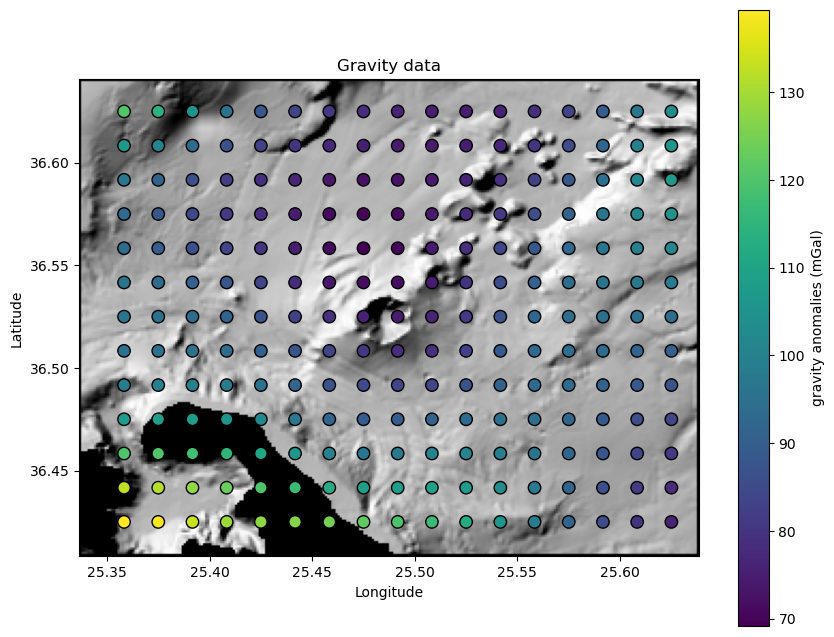

In [ ]:
# Read the GeoTIFF file
geotiff_path = './high_res_DEM.tif'  
with rasterio.open(geotiff_path) as src:
    geotiff_data = src.read(1)  
    extent = src.bounds         

# Plot the GeoTIFF
fig, ax = plt.subplots(figsize=(10, 8))
show(geotiff_data, transform=src.transform, extent=extent, ax=ax, cmap='gray')

# Overlay the scatterplot
scatter = ax.scatter(
    lon, lat, c=z, cmap='viridis', s=80, edgecolor='black'
)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('gravity anomalies (mGal)')

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Gravity data')

plt.show()


### Define an OcTree Mesh

In [65]:
dx = 5  # minimum cell width (base mesh cell width) in x
dy = 5  # minimum cell width (base mesh cell width) in y
dz = 5  # minimum cell width (base mesh cell width) in z

x_length = 240.0  # domain width in x
y_length = 240.0  # domain width in y
z_length = 120.0  # domain width in z

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Refine based on surface topography
mesh = refine_tree_xyz(
    mesh, xyz_topo, octree_levels=[2, 2], method="surface", finalize=False
)

# Refine box based on region of interest
xp, yp, zp = np.meshgrid([-100.0, 100.0], [-100.0, 100.0], [-80.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]

mesh = refine_tree_xyz(mesh, xyz, octree_levels=[2, 2], method="box", finalize=False)

mesh.finalize()

/var/folders/kv/9c2wczl17lzbpv6zgms9ms480000gn/T/ipykernel_48437/2250962203.py:18: FutureWarning:

In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.

/var/folders/kv/9c2wczl17lzbpv6zgms9ms480000gn/T/ipykernel_48437/2250962203.py:21: DeprecationWarning:

The surface option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_surface` functionality. It will be removed in a future version of discretize.

/var/folders/kv/9c2wczl17lzbpv6zgms9ms480000gn/T/ipykernel_48437/2250962203.py:29: DeprecationWarning:

The box option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_bounding_box` functionality. It will be removed in a future version of discretize.



### Create magma chamber in synthetic model

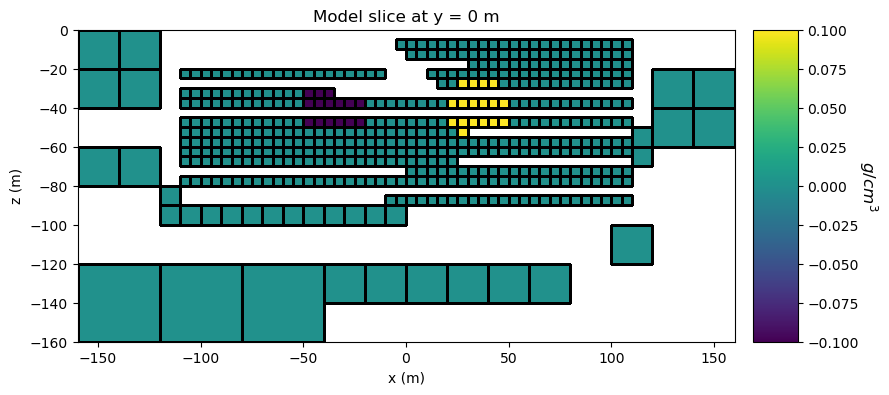

In [67]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.1
sphere_density = 0.1

# Find the indecies for the active mesh cells (e.g. cells below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells. The model consists of a value for
# each cell below the Earth's surface.
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model will be value of active cells

# Define model. Models in SimPEG are vector arrays.
model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (mesh.gridCC[ind_active, 0] > -50.0)
    & (mesh.gridCC[ind_active, 0] < -20.0)
    & (mesh.gridCC[ind_active, 1] > -15.0)
    & (mesh.gridCC[ind_active, 1] < 15.0)
    & (mesh.gridCC[ind_active, 2] > -50.0)
    & (mesh.gridCC[ind_active, 2] < -30.0)
)
model[ind_block] = block_density

# You can also use SimPEG utilities to add structures to the model more concisely
ind_sphere = model_builder.get_indices_sphere(
    np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_density

# Plot Density Contrast Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()